In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2
import os
from keras import layers
from keras import Model
from keras.applications.inception_v3 import InceptionV3

In [26]:
train_dir = r"D:\thetest\Railway-Track-fault-Detection-Project-main\content\Railway Track fault Detection Updated\Train"
validation_dir = r"D:\thetest\Railway-Track-fault-Detection-Project-main\content\Railway Track fault Detection Updated\Validation"

# Directory with our training defective/nondefective pictures
train_defective_dir = r"D:\thetest\Railway-Track-fault-Detection-Project-main\content\Railway Track fault Detection Updated\Train\Defective"
train_nondefective_dir = r"D:\thetest\Railway-Track-fault-Detection-Project-main\content\Railway Track fault Detection Updated\Train\Non Defective"

# Directory with our validation defective/nondefective pictures
validation_defective_dir = r"D:\thetest\Railway-Track-fault-Detection-Project-main\content\Railway Track fault Detection Updated\Validation\Defective"
validation_nondefective_dir = r"D:\thetest\Railway-Track-fault-Detection-Project-main\content\Railway Track fault Detection Updated\Validation\Non Defective"

In [27]:
train_defective_fnames = os.listdir(train_defective_dir )
train_nondefective_fnames = os.listdir( train_nondefective_dir)

print(train_defective_fnames[:20])
print(train_nondefective_fnames[:20])

['131004959_171473721383413_8222187747086021011_n.jpg', '131051004_382613492830631_1306891331783850055_n.jpg', '131065180_999185033824671_7735147288489715620_n.jpg', '131084537_190751489449739_279862595635733772_n.jpg', '131092897_149705809860659_8798464983059531038_n.jpg', '131098429_134147575143001_1246437012995704959_n.jpg', '131129946_140815574232570_8925999503657494497_n.jpg', '131275810_2686956714949012_5021348409242545922_n.jpg', '131348023_405054987354853_8834671660058234194_n.jpg', '131437543_500273490949549_5045378072687137331_n.jpg', '2007.05.16_-_002_Broken_rail_weld_-_Flickr_-_faxepl (1).jpg', '2007.05.16_-_002_Broken_rail_weld_-_Flickr_-_faxepl.jpg', '6411009.jpg', '89e8b1a9ca8c41919021f8f4faaf37f0.jpg', 'azer2003120026fbtr.jpg', 'b17bf671d87cb6c9d6cfcd2aafc8e13a.jpg', 'Broken_railroad_tracks_1.jpg', 'cracked-rail.webp', 'damagetotrackfromcollisionlfb.jpg', 'dbb9223f7e652986a00c0dd8d8f1ccf8 (1).jpg']
['IMG_20201114_100021.jpg', 'IMG_20201114_100032.jpg', 'IMG_20201114_100

In [28]:
print('total training defective images :', len(os.listdir(train_defective_dir)))
print('total training non-defective images :', len(os.listdir(train_nondefective_dir)))


print('total validation defective images :', len(os.listdir( validation_defective_dir ) ))
print('total validation non-defective images :', len(os.listdir( validation_nondefective_dir) ))

total training defective images : 150
total training non-defective images : 150
total validation defective images : 31
total validation non-defective images : 31


In [29]:
# Parameters for our graph; we'll output images in a 10x10 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

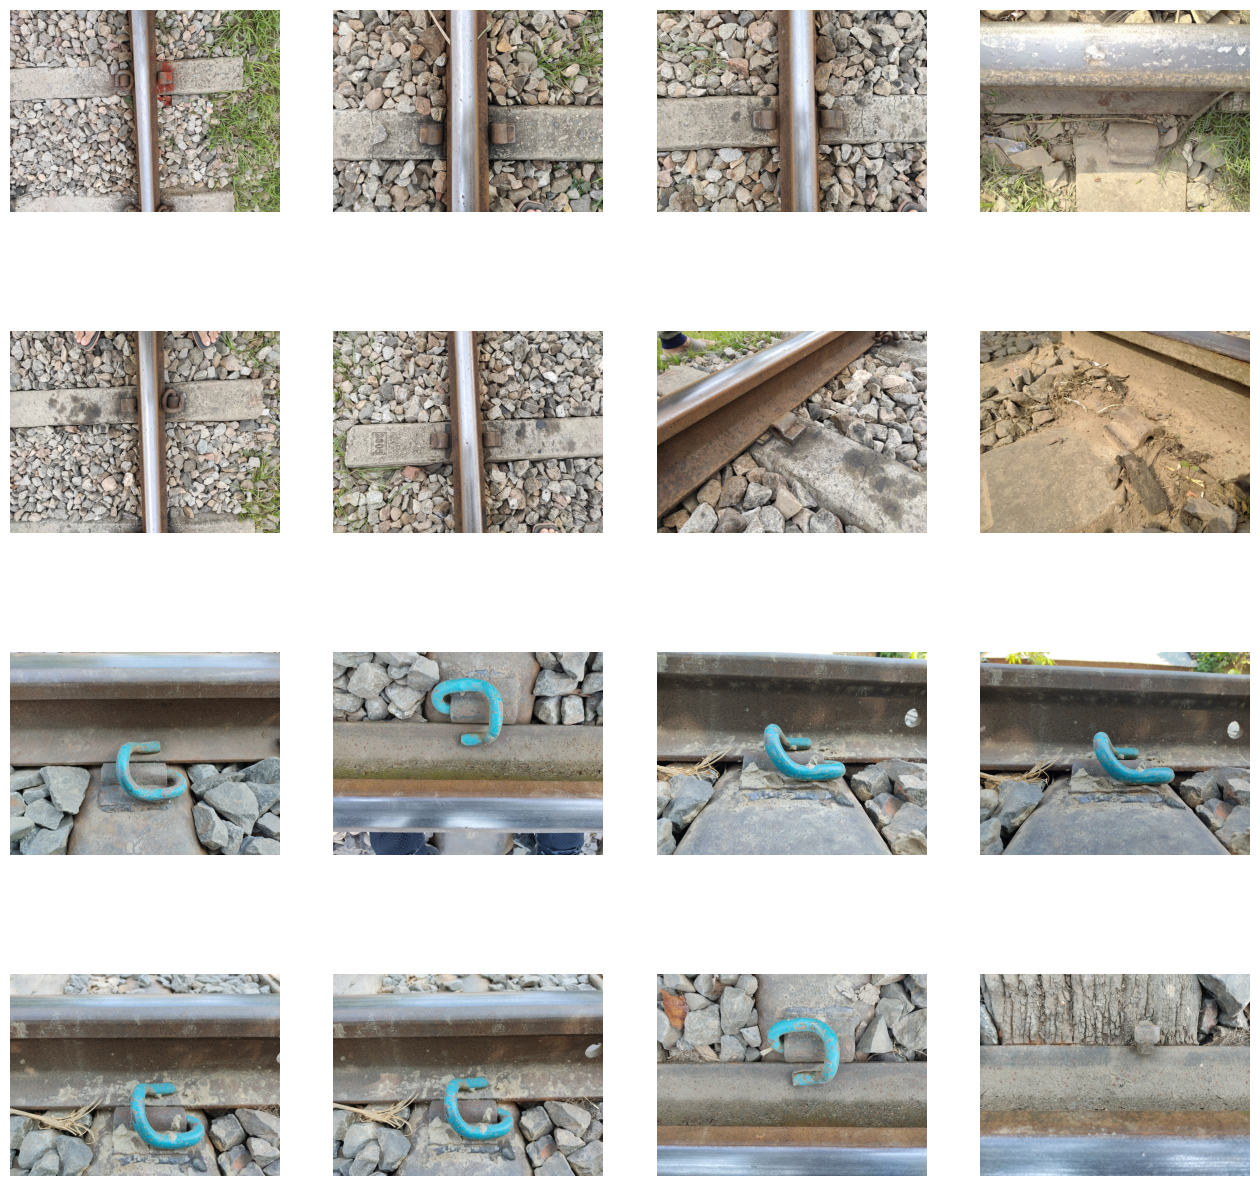

In [30]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_defective_pix = [os.path.join(train_defective_dir, fname) 
                for fname in train_defective_fnames[pic_index-8:pic_index]]
next_nondefective_pix = [os.path.join(train_nondefective_dir, fname) 
                for fname in train_nondefective_fnames[pic_index-8:pic_index]]


for i, img_path in enumerate(next_defective_pix+next_nondefective_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [31]:
local_weights_file = r"D:\thetest\Railway-Track-fault-Detection-Project-main\content\inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"


pre_trained_model = InceptionV3(input_shape = (300,300, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalizati

In [32]:
#data preprocessing
from keras.preprocessing.image import ImageDataGenerator


# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(300,300))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (300,300))

Found 299 images belonging to 2 classes.
Found 62 images belonging to 2 classes.


In [33]:
from keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(32, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = 'Adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

In [35]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              epochs=25,                            
                              verbose=2)

Epoch 1/25
15/15 - 45s - loss: 2.5096 - accuracy: 0.5151 - val_loss: 0.4464 - val_accuracy: 0.7903 - 45s/epoch - 3s/step
Epoch 2/25
15/15 - 39s - loss: 0.7410 - accuracy: 0.6856 - val_loss: 0.5456 - val_accuracy: 0.7742 - 39s/epoch - 3s/step
Epoch 3/25
15/15 - 38s - loss: 0.5785 - accuracy: 0.7224 - val_loss: 0.4762 - val_accuracy: 0.7258 - 38s/epoch - 3s/step
Epoch 4/25
15/15 - 37s - loss: 0.5170 - accuracy: 0.7458 - val_loss: 0.4555 - val_accuracy: 0.7742 - 37s/epoch - 2s/step
Epoch 5/25
15/15 - 36s - loss: 0.4466 - accuracy: 0.7659 - val_loss: 0.4923 - val_accuracy: 0.7903 - 36s/epoch - 2s/step
Epoch 6/25
15/15 - 38s - loss: 0.5025 - accuracy: 0.7324 - val_loss: 0.4519 - val_accuracy: 0.7903 - 38s/epoch - 3s/step
Epoch 7/25
15/15 - 37s - loss: 0.4708 - accuracy: 0.7324 - val_loss: 0.4102 - val_accuracy: 0.8387 - 37s/epoch - 2s/step
Epoch 8/25
15/15 - 37s - loss: 0.4948 - accuracy: 0.7458 - val_loss: 0.5588 - val_accuracy: 0.5968 - 37s/epoch - 2s/step
Epoch 9/25
15/15 - 37s - loss: 0

In [36]:
model_save_name=model.save('mymodel.h5',history)
print('model save successfully')

c:\Users\A\.conda\envs\rail\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model save successfully


Text(0.5, 1.0, 'Training and validation loss')

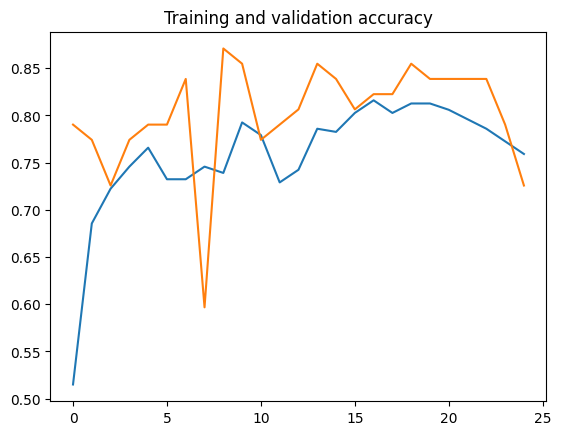

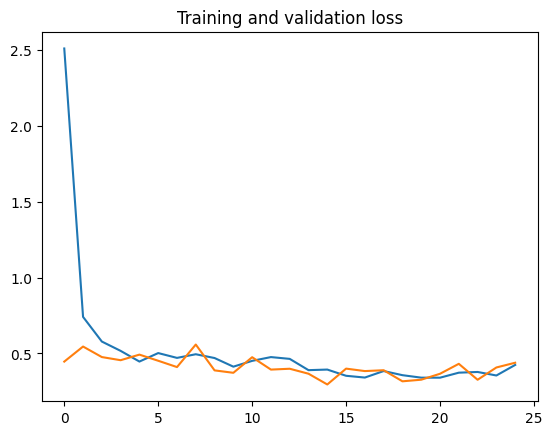

In [37]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'  )

1/1 [==============================] - 0s 82ms/step
[[1.]]
This Railway track has no fault


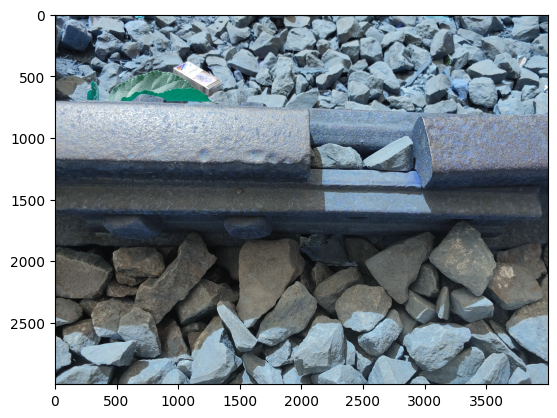

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread(r"D:\thetest\Railway-Track-fault-Detection-Project-main\content\Railway Track fault Detection Updated\Test\Defective\IMG_20201114_102203.jpg")
plt.imshow(img)
img = cv2.resize(img,(300,300))
img = np.reshape(img,[1,300,300,3])

classes = model.predict(img)

print(classes)
if classes>0.5:
    print("This Railway track has no fault")
else:
    print("This Railway track has fault")

1/1 [==============================] - 0s 82ms/step
[[1.]]
This Railway track has no fault


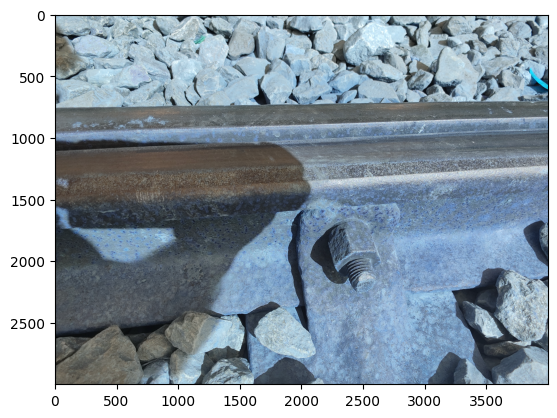

In [43]:
img = cv2.imread(r"D:\thetest\Railway-Track-fault-Detection-Project-main\content\Railway Track fault Detection Updated\Test\Non defective\IMG_20201114_101907.jpg")
plt.imshow(img)
img = cv2.resize(img,(300,300))
img = np.reshape(img,[1,300,300,3])

classes = model.predict(img)

print(classes)
if classes>0.5:
    print("This Railway track has no fault")
else:
    print("This Railway track has fault")